In [1]:
from processed_image import ProcessedImage, read_from_dir, show_image_strip
imgs = list(read_from_dir('..\\Data\\LittleCarDb1'))
[str(img) for img in imgs[0:5]]

['ProcessedImage for ..\\Data\\LittleCarDb1\\SF0781-001_1.jpg (0 in cache)',
 'ProcessedImage for ..\\Data\\LittleCarDb1\\SF0781-002_1.jpg (0 in cache)',
 'ProcessedImage for ..\\Data\\LittleCarDb1\\SF0781-003_1.jpg (0 in cache)',
 'ProcessedImage for ..\\Data\\LittleCarDb1\\SF0781-004_1.jpg (0 in cache)',
 'ProcessedImage for ..\\Data\\LittleCarDb1\\SF0781-005_1.jpg (0 in cache)']

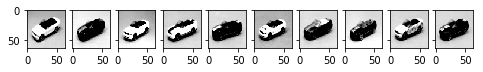

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
_, axes = plt.subplots(1, 10, sharey=True, figsize=(8,1.5))
show_image_strip(imgs, axes)
show_processed_strip = True
if show_processed_strip:
    datagen = ImageDataGenerator()
    transform_parameters = {
        'theta':40,
        'tx':-7.0,
        'ty':5.0,
        'zx':0.9,
        'zy':0.9
    }
    def transform(img):
        return datagen.apply_transform(x=img, 
                                       transform_parameters=transform_parameters)
    _, axes = plt.subplots(2, 10, sharey=True, figsize=(8,1.5))
    processed_dict = {img.fullpath:transform(img.get_processed_image()) for img in imgs}
    show_image_strip(imgs, axes, predicted_dict=processed_dict)

In [3]:
use_cpu = False
if use_cpu:
    import os
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
from model_vae_3stage import ModelVae3Stage
all_model = ModelVae3Stage(size=256, in_channels=1, latent_dim=8)
vae, enc, dec = all_model.vae, all_model.encoder, all_model.decoder

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [4]:
import numpy as np
import random
random.shuffle(imgs)
x_train = [img.get_processed_image(size=256) for img in imgs]
x_train = np.array(x_train)
x_train = np.reshape(x_train, 
                     (x_train.shape[0], 
                      x_train.shape[1], 
                      x_train.shape[2], 1))

test_size = len(x_train) // 10
x_test = x_train[0:test_size]
x_train = x_train[test_size+1:]
x_train.shape, x_test.shape

((579, 256, 256, 1), (64, 256, 256, 1))

In [13]:
use_generator = True
if use_generator:
    def generator(x_train, batch_size):
        # Create empty arrays to contain batch of features and labels
        batch_train = np.zeros((batch_size, 
                                x_train.shape[1], 
                                x_train.shape[2], 
                                x_train.shape[3]))
        while True:
            for i in range(batch_size):
                # choose random index in features
                batch_train[i] = random.choice(x_train)
            yield batch_train, batch_train
    vae.fit_generator(generator(x_train, batch_size=256), 
                      steps_per_epoch=50, epochs=100)
else:
    vae.fit(x_train, x_train, epochs=500, batch_size=256,
        shuffle=True, validation_data=(x_test,x_test))

Epoch 1/100
50/50 [==============================] - 31s 614ms/step - loss: 1086.5599
Epoch 2/100
50/50 [==============================] - 31s 616ms/step - loss: 975.3805
Epoch 3/100
50/50 [==============================] - 31s 618ms/step - loss: 958.2256
Epoch 4/100
50/50 [==============================] - 31s 627ms/step - loss: 975.6178
Epoch 5/100
50/50 [==============================] - 31s 626ms/step - loss: 957.2167
Epoch 6/100
50/50 [==============================] - 31s 628ms/step - loss: 955.8933
Epoch 7/100
50/50 [==============================] - 31s 620ms/step - loss: 950.5326
Epoch 8/100
50/50 [==============================] - 31s 620ms/step - loss: 970.4802
Epoch 9/100
50/50 [==============================] - 31s 620ms/step - loss: 976.7813
Epoch 10/100
50/50 [==============================] - 31s 620ms/step - loss: 959.5222
Epoch 11/100
50/50 [==============================] - 31s 620ms/step - loss: 940.9966
Epoch 12/100
50/50 [==============================] - 31s 624m

50/50 [==============================] - 31s 618ms/step - loss: 882.9032
Epoch 97/100
50/50 [==============================] - 31s 618ms/step - loss: 852.6296
Epoch 98/100
50/50 [==============================] - 31s 618ms/step - loss: 875.4975
Epoch 99/100
50/50 [==============================] - 31s 616ms/step - loss: 903.5283
Epoch 100/100
50/50 [==============================] - 31s 618ms/step - loss: 855.6414


In [14]:
def show_original_decoded(original, decoded, sz):
    from scipy import ndimage, misc
    from skimage.transform import resize
    
    n = 8  # how many digits we will display
    plt.figure(figsize=(n*2, 4))
    for i in range(n):
        
        ax = plt.subplot(2, n, i+1)
        orig_image = original[i].reshape(sz,sz)
        plt.imshow(orig_image, cmap='gray')
        
        ax = plt.subplot(2, n, i+1+n)
        decoded_image = decoded[i].reshape(sz,sz)
        plt.imshow(decoded_image, cmap='gray')
    plt.show()

(8, 256, 256, 1) -> (8, 8) -> (8, 256, 256, 1)


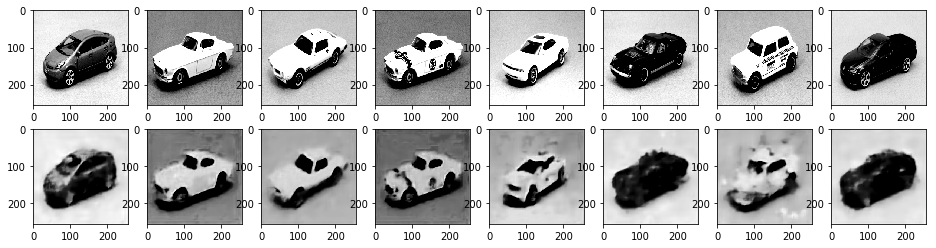

In [15]:
show_examples = np.append(x_train[0:4], x_test[0:4], axis=0)
encoded_latent = enc.predict(show_examples)[2]   # z parameter is #2
decoded_imgs = dec.predict(encoded_latent)
print(show_examples.shape, '->', encoded_latent.shape, '->', decoded_imgs.shape)
show_original_decoded(show_examples, decoded_imgs, 256)

In [16]:
vae.save('model_vae_3stage.h5')

In [17]:
with open("model_vae_3stage.yaml", "w") as yaml_model_file:
    yaml_model_file.write(vae.to_yaml())

In [18]:
import matplotlib.pyplot as plt
sz=256
def g(**kwargs):
    plt.figure(2, figsize=(4,4))
    # x = np.linspace(-10,10,num=1000)
    # plt.plot(x,kwargs['1']/100*x + kwargs['2'])
    # plt.ylim(-5,5)
    # plt.show()
    latent = np.array([list(kwargs.values())])
    # print(type(latent))
    # print(latent.shape)
    # latent.reshape(1,)
    # print(latent)
    decoded = dec.predict(latent)
    plt.imshow(decoded.reshape(sz,sz))
    plt.gray()
    return kwargs['1']

In [19]:
from ipywidgets import interactive_output,Layout
import ipywidgets as widgets

In [20]:
%matplotlib inline
latent_dim = encoded_latent[2].shape[-1]
def createSlider():
    return widgets.FloatSlider(value=0,
                               min=-1, max=1, step=0.01,
                               orientation='vertical',
                               layout=Layout(padding='0%'))
kwargs = {str(k):createSlider() for k in range(latent_dim)}
w = interactive_output(g,kwargs)
hbox = widgets.HBox(list(kwargs.values()),
                    layout=Layout(padding='0%'))
display(hbox,w)

Output()

In [ ]:
random.choice(np.array([[1,2,3,4,5]]))